In [1]:
import numpy as np
import argparse
import time
import os
import functools

import torch
from torchvision.transforms import Grayscale
from config.config import get_arguments
from utils.functions import *
from utils.loader import *
from utils.runner import *
from utils.augmentation import JitAugment, RandAug

from albumentations.pytorch import ToTensorV2

from skimage import io
import matplotlib.pyplot as plt
from matplotlib import gridspec

/home/dima/torch/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
opt = argparse.Namespace(dir_path='imgs/',
                        dir_test_path='test/',
                        not_cuda = 0,
                        manualSeed=3407,
                        #is_mask=True,
                        gpu=0,
                        min_size=25,
                        max_size=256,
                        scale_factor=0.75,
                        img_shape=(256, 256),
                        num_classes=6,
                        num_data=16,
                        batch_size=4,
                        losses = ['ssim11','mse'],         #['ssim11'], ['ssim11','mse'],
                        scale_num=1,
                        beta1=0.5,
                        beta2=0.999,
                        niter=300,
                        d_niter=100,
                        pixel_shuffle_p=0.1,
                        nc_im=3,
                        nfc=128,
                        nfg=64,
                        z_dim=100,
                        lr=1e-3
                        )
opt = post_config(opt)

In [3]:
dir2save = generate_dir2save(opt)
try:
    os.makedirs(dir2save)
except OSError:
    pass

runner = Runner(PathologyLoader, dir2save, opt)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /home/dima/torch/lib/python3.8/site-packages/lpips/weights/v0.1/vgg.pth


In [4]:
#runner.train_d()

In [27]:
runner.niter = 300
runner.lr = 1e-4
runner.train_self()

100%|█| 300/300 [00:50<00:00,  5.96it/s, TOT:1.0051, LPIPS:0.0963, SSIM:0.0676, MSE:0


In [28]:
#runner.train()

In [29]:
trained_net = runner.net_gen
trained_d = runner.d_net

In [30]:
train_loader_iter = runner.train_loader_iter
test_loader_iter = runner.test_loader_iter

In [31]:
#print(l, lt)

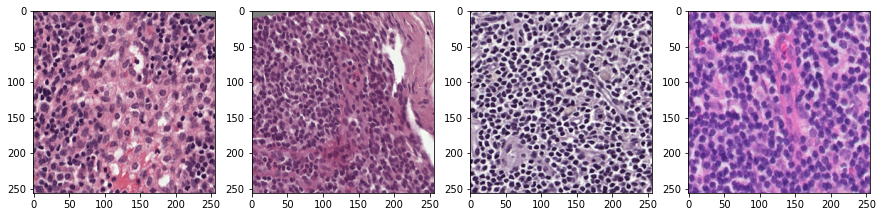

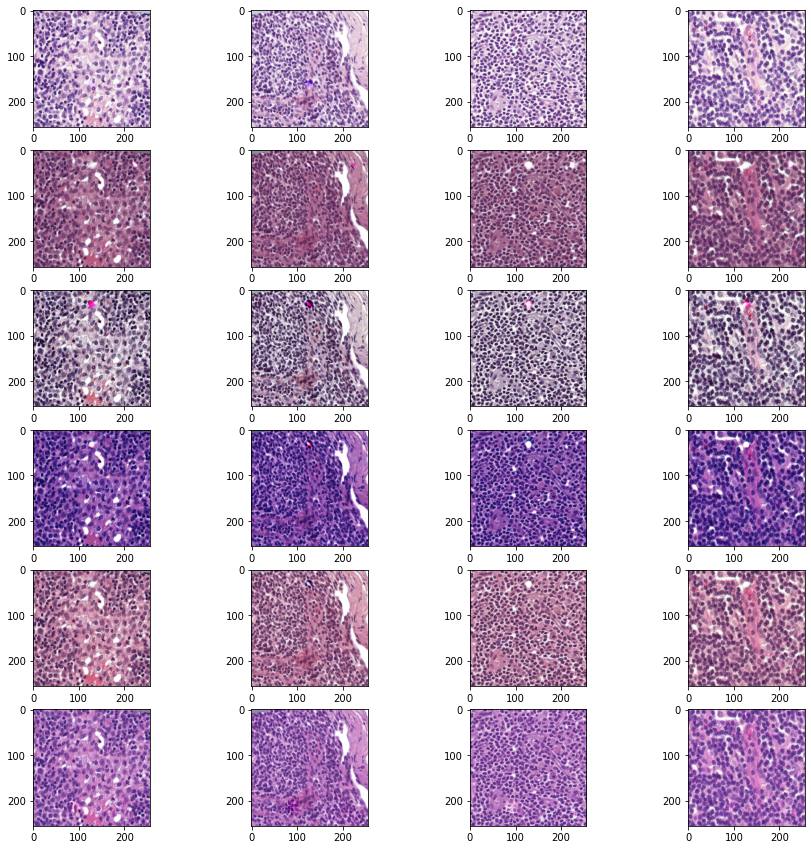

In [32]:
x, l = next(train_loader_iter)

fig = plt.figure(figsize=(15,15))
rows = 1
cols = opt.batch_size
spec = gridspec.GridSpec(ncols=cols, nrows=1)

for i in range(cols):
    ax = fig.add_subplot(spec[i])
    ax.imshow(convert_image_np(x[i].detach()))
    
fig = plt.figure(figsize=(15,15))
rows = runner.num_classes
cols = opt.batch_size
spec = gridspec.GridSpec(ncols=cols, nrows=rows)

for i in range(rows):
    # infer = trained_net(x.cuda(), torch.eye(runner.num_classes)[torch.tensor([[i+4]]*rows)].cuda())
    infer = trained_net(x.cuda(), torch.eye(runner.num_classes)[torch.tensor([i]*cols)].cuda())
    for j in range(cols):
        ax = fig.add_subplot(spec[i*cols + j])
        ax.imshow(convert_image_np(infer[j].detach()))

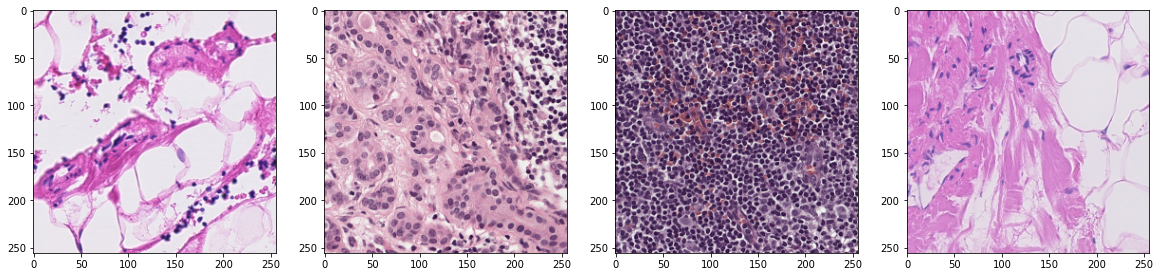

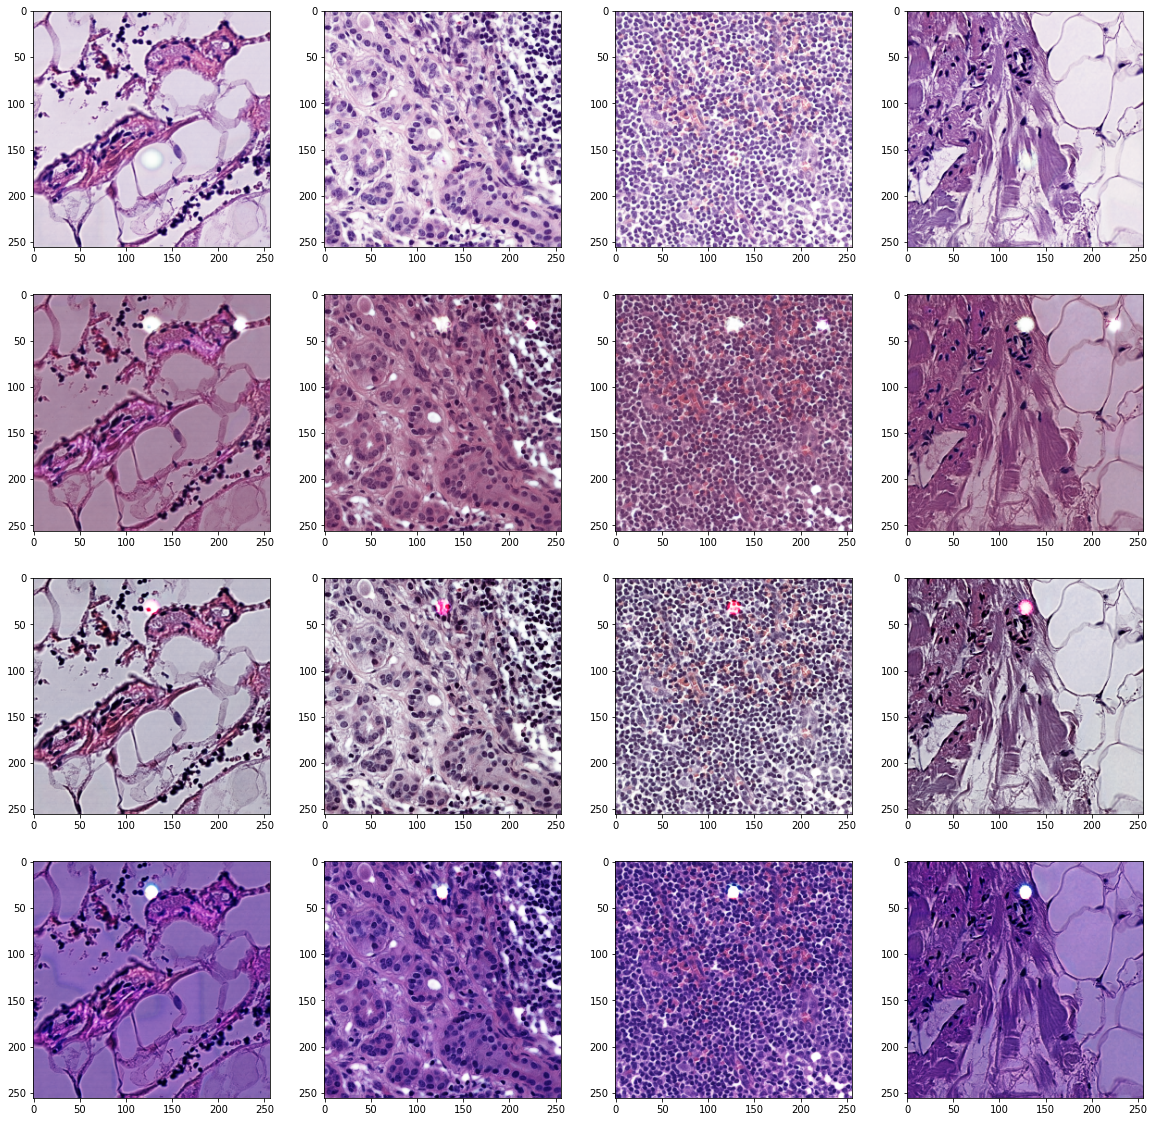

In [33]:
t, lt = next(test_loader_iter)

fig = plt.figure(figsize=(20,20))
rows = 4
cols = 1
spec = gridspec.GridSpec(ncols=4, nrows=1)

for i in range(rows):
    ax = fig.add_subplot(spec[i])
    ax.imshow(convert_image_np(t[i].detach()))
    
fig = plt.figure(figsize=(20,20))
rows = 4
cols = 4
spec = gridspec.GridSpec(ncols=4, nrows=4)

for i in range(rows):
    infer = trained_net(t.cuda(), torch.eye(runner.num_classes)[torch.tensor([[i]]*4)].cuda())
    for j in range(cols):
        ax = fig.add_subplot(spec[i*rows + j])
        ax.imshow(convert_image_np(infer[j].detach()))

In [17]:
from metric.psnr import PSNR
from metric.ssim import SSIM, MS_SSIM


In [18]:
psnr = PSNR(data_range=1.0)
ssim = SSIM(data_range=1.0, win_size=11, nonnegative_ssim=True)
msssim = MS_SSIM(data_range=1.0, win_size=11)

In [19]:
l

tensor([1, 5, 4, 5])

In [20]:
[i for i in range(6)]

[0, 1, 2, 3, 4, 5]

In [21]:
l

tensor([1, 5, 4, 5])

In [56]:
x, l = next(train_loader_iter)
xt, lxt = next(test_loader_iter)

y = trained_net(xt.cuda(), torch.eye(6)[l].cuda())
for i in range(4):
    print(f'psnr : {psnr(xt[i].cuda(), y[i])}')
    print(f'ssim : {ssim(xt[i].cuda().unsqueeze(0), y[i].unsqueeze(0))}')
    print(f'msssim : {msssim(xt[i].cuda().unsqueeze(0), y[i].unsqueeze(0))}')

psnr : 7.951023578643799
ssim : 0.27483057975769043
msssim : 0.5097576975822449
psnr : 3.4565508365631104
ssim : 0.15361396968364716
msssim : 0.2781856060028076
psnr : 29.081790924072266
ssim : 0.9226436614990234
msssim : 0.9833769798278809
psnr : 10.638657569885254
ssim : 0.5284699201583862
msssim : 0.70909583568573


In [55]:
y = trained_net(x.cuda(), torch.eye(6)[l].cuda())
for i in range(4):
    print(psnr(x[i].cuda(), y[i]))
    print(ssim(x[i].cuda().unsqueeze(0), y[i].unsqueeze(0)))
    print(msssim(x[i].cuda().unsqueeze(0), y[i].unsqueeze(0)))

tensor(22.7093, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9043, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9782, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(33.1384, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9817, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9972, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(31.4996, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.9688, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9963, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(23.4328, device='cuda:0', grad_fn=<MulBackward0>)
tensor(0.8641, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.9597, device='cuda:0', grad_fn=<MeanBackward0>)


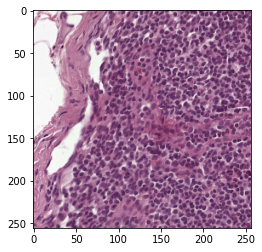

In [57]:
plt.imshow(convert_image_np(xt[2].detach()))

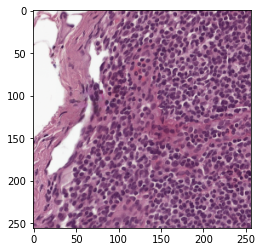

In [58]:
plt.imshow(convert_image_np(y[2].detach()))

### save

In [30]:
runner.save()

In [34]:
print(runner.save_dir)

runner.save_dir = 'TrainedModels/2022_10_13_00_12_12/'
runner.load()
loaded_net = runner.net_gen

TrainedModels/2022_10_13_00_08_20/


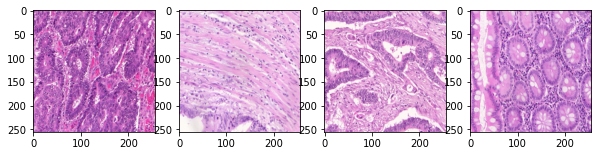

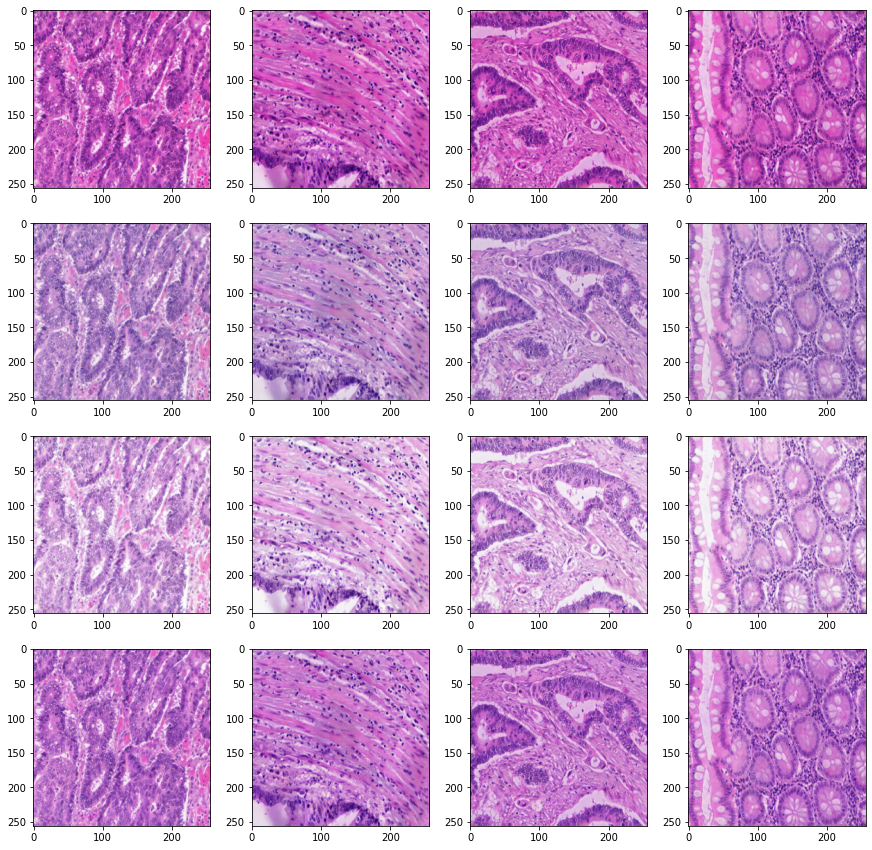

In [36]:
fig = plt.figure(figsize=(10,10))
rows = 4
cols = 1
spec = gridspec.GridSpec(ncols=4, nrows=1)

for i in range(rows):
    ax = fig.add_subplot(spec[i])
    ax.imshow(convert_image_np(t[i].detach()))
    
fig = plt.figure(figsize=(15,15))
rows = 4
cols = 4
spec = gridspec.GridSpec(ncols=4, nrows=4)

for i in range(rows):
    infer = loaded_net(t.cuda(), torch.eye(4)[torch.tensor([l[i]]*4)].cuda())
    for j in range(cols):
        ax = fig.add_subplot(spec[i*rows + j])
        ax.imshow(convert_image_np(infer[j].detach()))

In [ ]:
G = Grayscale(num_output_channels=3)

In [ ]:
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        if img.shape[0] == 3:
            img = convert_image_np(img)
        axs[0, i].imshow(img)
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [ ]:
from torchvision.utils import make_grid

grid = make_grid(x, padding=4)
show(grid)

rows = 2
cols = 4
fig, axs = plt.subplots(ncols=cols, nrows=rows, figsize=(15,15))

for i in range(cols):
    for j in range(rows):
        axs[j, i].imshow(convert_image_np(x[i].detach()))
        axs[j, i].imshow(convert_image_np(x[i].detach()))

plt.show()

In [70]:
original_idx = torch.arange(5 * 5)
shuffle_idx = torch.randperm(5*5)
print(original_idx)
print(shuffle_idx)

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24])
tensor([18, 15,  6,  0,  1,  7, 16,  5,  8,  9, 14, 19, 11, 23, 21,  2, 24, 20,
        10, 13, 22,  3,  4, 17, 12])


In [68]:
print(*original_idx.shape)
rand_idx = torch.rand(*original_idx.shape)

25


In [72]:
rand_idx > 0.3

tensor([ True,  True,  True, False, False,  True,  True, False, False, False,
         True,  True,  True,  True,  True,  True, False, False,  True,  True,
        False, False, False, False,  True])

In [74]:
torch.where(rand_idx > 0.3, original_idx, shuffle_idx)

tensor([ 0,  1,  2,  0,  1,  5,  6,  5,  8,  9, 10, 11, 12, 13, 14, 15, 24, 20,
        18, 19, 22,  3,  4, 17, 24])

In [113]:
def shuffle_pixel(x, p=0.3):
    if p == 0:
        return x.clone()

    b, c, h, w = x.shape
    out = x.clone()
    original_idx = torch.arange(h * w)
    shuffle_idx = torch.randperm(h * w)
    shuffle_idx = torch.where(torch.rand(*original_idx.shape) > p, original_idx, shuffle_idx)

    out = out.view(b, 3, -1)[:, :, shuffle_idx].view(*out.shape)
    return out

In [120]:
out = shuffle_pixel(x, 0.005)

torch.Size([4, 3, 256, 256])
torch.Size([65536])


In [121]:
out.shape

torch.Size([4, 3, 256, 256])

In [22]:
G = Grayscale(num_output_channels=3)

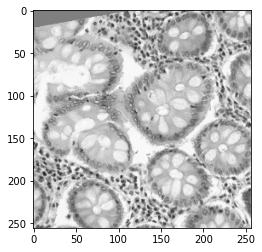

In [23]:
plt.imshow(convert_image_np(G(x[1]).detach()))

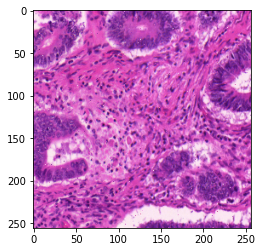

In [123]:
plt.imshow(convert_image_np(out[1].detach()))

In [104]:
out[:, :, [0, 1, 0, 2, 3]].shape

torch.Size([4, 3, 5])

In [103]:
out[:, :, [0, 1, 0, 2, 3]].view(4, 3, 5)

tensor([[[ 0.3762,  0.2339,  0.3762,  0.1411,  0.0576],
         [ 0.0362, -0.0327,  0.0362, -0.1545, -0.2204],
         [ 0.5723,  0.4589,  0.5723,  0.3593,  0.2113]],

        [[ 0.7640,  0.8767,  0.7640,  0.7631,  0.8396],
         [ 0.2034,  0.2462,  0.2034,  0.0863,  0.1019],
         [ 0.6861,  0.7907,  0.6861,  0.7042,  0.7150]],

        [[ 0.3034,  0.3390,  0.3034,  0.3706,  0.4315],
         [-0.2118, -0.2104, -0.2118, -0.2653, -0.2143],
         [ 0.5528,  0.5378,  0.5528,  0.4290,  0.4701]],

        [[ 0.7494,  0.7505,  0.7494,  0.7641,  0.8023],
         [ 0.3209,  0.2993,  0.3209,  0.3808,  0.4641],
         [ 0.7099,  0.7457,  0.7099,  0.7475,  0.7739]]])

In [77]:
shuffle_pixel(x).shape

torch.Size([4, 3, 256, 256])
torch.Size([65536])


torch.Size([4, 3, 65536])

In [43]:
256*256

65536

In [18]:
sour_idx = 3
tar_idx = 3

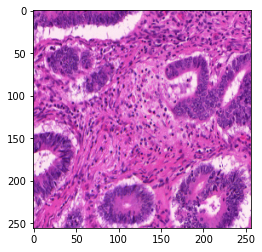

In [19]:
plt.imshow(convert_image_np(x[sour_idx]))

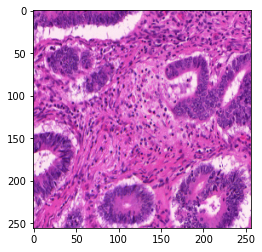

In [20]:
plt.imshow(convert_image_np(x[tar_idx]))

In [21]:
infer = trained_net(x[sour_idx:sour_idx+1].cuda(), torch.eye(4)[tar_idx].cuda())
print(f'target : {tar_idx}, results: {torch.argmax(trained_d(infer)).item()}')

target : 3, results: 2


In [48]:
rec = trained_net(infer, torch.eye(4)[sour_idx].cuda())
print(f'source : {sour_idx}, results: {torch.argmax(trained_d(rec)).item()}')

source : 3, results: 2


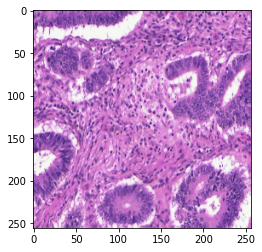

In [52]:
plt.imshow(convert_image_np(infer[0].detach()))

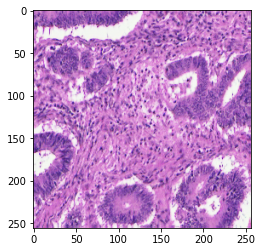

In [50]:
plt.imshow(convert_image_np(rec[0].detach()))

In [87]:
convert_image_np(infer[0].detach())

array([[[0.648128  , 0.35189486, 0.7319766 ],
        [0.5387777 , 0.26718485, 0.6675034 ],
        [0.5694376 , 0.25958395, 0.6148258 ],
        ...,
        [0.42383507, 0.17399979, 0.49625295],
        [0.68836105, 0.32081336, 0.5982884 ],
        [0.70567006, 0.31529075, 0.6941479 ]],

       [[0.46081924, 0.25663042, 0.5224425 ],
        [0.51033777, 0.28528252, 0.6663796 ],
        [0.57400995, 0.3222199 , 0.64974976],
        ...,
        [0.55394834, 0.24553955, 0.56871784],
        [0.8094421 , 0.40400127, 0.74708384],
        [0.667033  , 0.36821094, 0.67442644]],

       [[0.5597406 , 0.28233635, 0.647527  ],
        [0.67163944, 0.37822154, 0.762704  ],
        [0.66389513, 0.36994582, 0.74410504],
        ...,
        [0.7214941 , 0.33500814, 0.7370641 ],
        [0.7106326 , 0.38443968, 0.7490804 ],
        [0.5902001 , 0.2512399 , 0.7338129 ]],

       ...,

       [[0.86750853, 0.44141054, 0.8155757 ],
        [0.81434476, 0.40331757, 0.74689084],
        [0.7860007 , 0

In [44]:
trained_d(infer)

tensor([[8.0100, 3.5971, 8.7610, 9.0502]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [17]:
trained_d(rec)

tensor([[1.1258, 2.6227, 7.5495, 2.6084]], device='cuda:0',
       grad_fn=<ReshapeAliasBackward0>)

In [21]:
import torch.nn as nn

In [47]:
ce = nn.CrossEntropyLoss()

In [73]:
x = torch.eye(4)[0]
l = torch.tensor([[18.8399,  4.6291,  6.6840, 13.8463]])
k = torch.tensor(0)
# tensor(0, device='cuda:0')
xxx = torch.eye(4)[[k.unsqueeze(0)]]

In [74]:
x, l, k, xx, xxx

(tensor([1., 0., 0., 0.]),
 tensor([[18.8399,  4.6291,  6.6840, 13.8463]]),
 tensor(0),
 tensor([[1., 0., 0., 0.]]),
 tensor([[1., 0., 0., 0.]]))

In [75]:
ce(l ,xxx)

tensor(0.0068)

In [62]:
torch.tensor(0)

tensor(0)

In [64]:
torch.eye(4)[torch.tensor([0,0,0,0])]


tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])

In [33]:
trained_d(rec).shape

torch.Size([1, 4])

In [29]:
x.shape

torch.Size([1, 4])

In [32]:
ce(trained_d(rec),x.cuda())

tensor(10.4372, device='cuda:0', grad_fn=<DivBackward1>)

In [9]:
x

tensor([1., 0., 0., 0.])

In [111]:
torch.rand(1, 1, 1, 1) - 0.5

tensor([[[[-0.2447]]]])

In [21]:
arr = torch.randn([1,3,10,11])

In [34]:
def convert_image_np(inp):
    # if len(inp.shape) == 4:
    if inp.shape[1]==3:
        inp = denorm(inp)
        inp = move_to_cpu(inp[:,:,:,:])
        
        inp = inp.numpy().transpose((0,2,3,1))
        print(inp.shape)
    else:
        inp = denorm(inp)
        inp = move_to_cpu(inp[:,-1,:,:])
        inp = inp.numpy().transpose((0,1))
    # else:
    #     if inp.shape[0]==3:
    #         inp = denorm(inp)
    #         inp = move_to_cpu(inp[:,:,:])
    #         inp = inp.numpy().transpose((1,2,0))
    #     else:
    #         inp = denorm(inp)
    #         inp = move_to_cpu(inp[-1,:,:])
    #         inp = inp.numpy().transpose((0,1))

    inp = np.clip(inp,0,1)
    return inp

(1, 10, 11, 3)


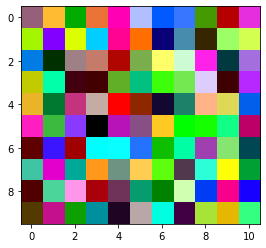

In [36]:
plt.imshow(convert_image_np(arr)[0])